Implied Volatility (annual) for AAPL: 0.3940
Implied Volatility (annual) for MSFT: 0.2320
Implied Volatility (annual) for GOOGL: 0.3500
Implied Volatility (annual) for AMZN: 0.3677
Implied Volatility (annual) for META: 0.3690


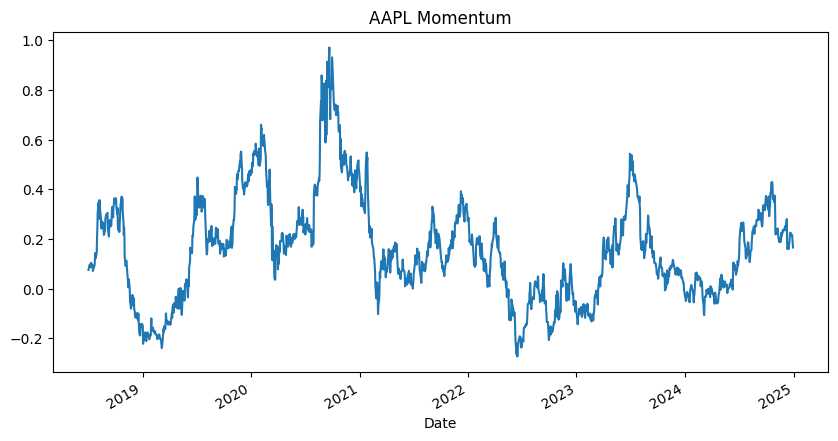

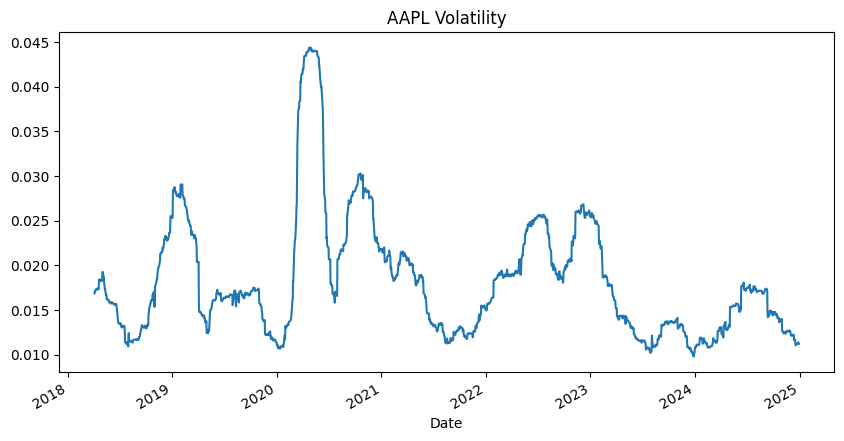

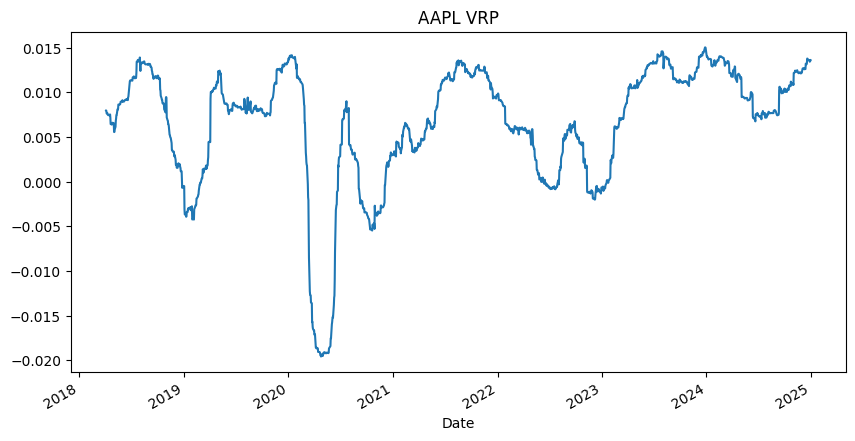

In [ ]:
import sys
import os
import yfinance as yf
import datetime

# Add the root directory (parent of notebooks/) to sys.path
project_root = os.path.abspath(os.path.join(os.getcwd(), "..")) #os.getcwd() returns current working directory, ".." goes one level up

if project_root not in sys.path:

    # Look for modules in project_root
    sys.path.insert(0, project_root)

import pandas as pd
from src.factors import calculate_momentum, calculate_volatility, calculate_zscore
from src.volatility_factors import calculate_realized_volatility, iv_realized_diff
from src.options_utils import black_scholes_call_price, implied_volatility_call
import matplotlib.pyplot as plt

# Load price data (taken from data_collection notebook)
adj_close = pd.read_csv("../data/processed/price_data.csv", index_col = 0, parse_dates = True)

# Compute momentum and volatility quant factors
momentum = calculate_momentum(adj_close) # Momentum - percentage change
volatility = calculate_volatility(adj_close) # Volatility - rolling standard deviation

# Using AAPL stock as a simple reference to calculated implied volatility
tickers = ["AAPL", "MSFT", "GOOGL", "AMZN", "META"]
iv_fixed = {}
for ticker in tickers:
    stock = yf.Ticker(ticker)

    # Get nearest expiration option
    options_dates = stock.options
    near_exp = options_dates[0]
    opt_chain = stock.option_chain(near_exp)

    # Pick an ATM (At The Money) call
    calls = opt_chain.calls
    spot = stock.history(period="1d")['Close'].iloc[0]
    atm_call = calls.iloc[(calls['strike'] - spot).abs().argsort()[:1]]


    # Parameters (market price, strike price, time to maturity, drift rate and spot price) used in calculating implied volatility based on Black-Scholes
    C_market = atm_call['lastPrice'].values[0]
    K = atm_call['strike'].values[0]
    T = (datetime.datetime.strptime(near_exp, "%Y-%m-%d") - datetime.datetime.today()).days / 365


    # Fetch risk-free rate from Yahoo Finance (3-month T-bill rate)
    t_bill = yf.Ticker("^IRX")
    r = t_bill.history(period = "1d")['Close'].iloc[-1] / 100  # Convert to decimal
    S = spot

    # Calculate and print out implied volatility estimate, ideally a daily forward series calculated over ndays would be appropriate, but for simplicity, I calculate 1 value and clone it.
    iv = implied_volatility_call(C_market, S, K, T, r)
    print(f"Implied Volatility (annual) for {ticker}: {iv:.4f}")

    # Convert implied volatility from annual to daily
    iv = iv / (252 ** 0.5)

    iv_fixed[ticker] = iv

# Dataframe of implied volatility and volatility risk premium (VRP)
iv_df = pd.DataFrame({ticker: [iv] * len(volatility) for ticker, iv in iv_fixed.items()},
                     index = volatility.index)

vrp = iv_realized_diff(iv_df, volatility)

# Calculate normalized z-scores for factors
z_momentum = calculate_zscore(momentum)
z_vrp      = calculate_zscore(vrp)

# Combine scores into one factor
combined_score = z_momentum + z_vrp

# Save to CSV
momentum.to_csv("../data/processed/momentum.csv")
volatility.to_csv("../data/processed/volatility.csv")
vrp.to_csv("../data/processed/volatility_risk_premium.csv")
combined_score.to_csv("../data/processed/momntm_vrp_combined.csv")

# Quick plots for verification
plt.figure(figsize = (10, 5))
momentum['AAPL'].plot(title = "AAPL Momentum")
plt.show()

plt.figure(figsize = (10, 5))
volatility['AAPL'].plot(title = "AAPL Volatility")
plt.show()

plt.figure(figsize = (10, 5))
vrp['AAPL'].plot(title = "AAPL VRP")
plt.show()
